# Assignment 1 - Variable Auto Encoder (VAE)

## Download FashionMNIST dataset

Resource for download code found at https://www.kaggle.com/code/adrynh/pytorch-tutorial-with-fashion-mnist

In [1]:
import torch
import torchvision
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Subset, random_split
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math
import copy
import random

In [2]:
torch.manual_seed(0)
random.seed(0)

In [3]:
# Download dataset via torchvision's library, then indicate to transform each image to a tensor
# This fn consequently normalizes the data 0 to 1 and it is shown when retrieving a sample from the dataset
train = torchvision.datasets.FashionMNIST(root='data', train=True, download=True, transform=ToTensor())
test = torchvision.datasets.FashionMNIST(root='data', train=False, download=True, transform=ToTensor())

In [4]:
# Create split of training and validation data from dataloader 90/10%
train_size = int(len(train) * 0.8)
val_size = len(train) - train_size
t, v = random_split(train, [train_size, val_size])

In [5]:
# Create iterable via torch.DataLoader function to allow passing minibatches, reshuffle data during each epoch and reduce model overfitting
all_train_data = DataLoader(train, batch_size=128, shuffle=True)
train_data = DataLoader(t, batch_size=128, shuffle=True)
val_data = DataLoader(v, batch_size=128, shuffle=False)
test_data = DataLoader(train, batch_size=128, shuffle=False)

In [6]:
# Proof of normalization applied when retrieving sample from dataset
sample, label = train[0][0], train[1]
train.data.size(), sample.min(), sample.max()

(torch.Size([60000, 28, 28]), tensor(0.), tensor(1.))

In [7]:
# Information about batches for faster processing
len(train_data), len(train_data)*128, len(val_data), len(val_data)*128

(375, 48000, 94, 12032)

## Visualize data via matplotlib

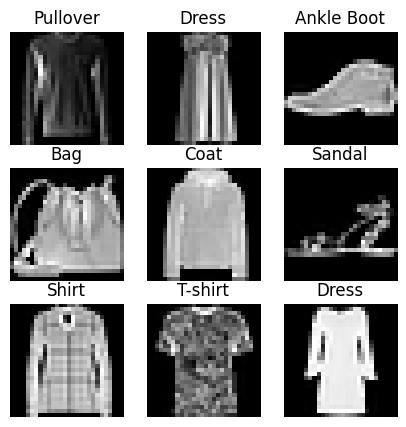

In [8]:
# Set available labels
labels_map={
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

# Create fig dimensions of 10 by 10 within train data and 3 by 3 for display purposes
fig = plt.figure(figsize=(5,5))
cols,rows = 3, 3

# Select at random, one image from each of the 10 categories in the train dataset, then create subplot for display
for i in range (1, cols*rows + 1):
    sample_idx = torch.randint(len(train), size = (1,)).item()
    image, label = train[sample_idx]
    fig.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
plt.show()

## Create Model via torch.nn allowing the application of train() and model() functions

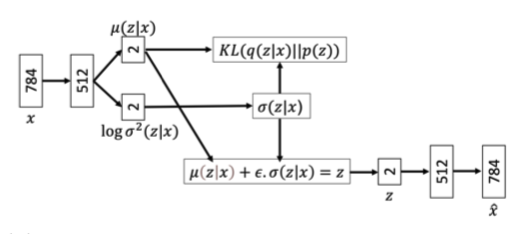

In [9]:
class VAE(nn.Module):
    # Initiate module via torch.nn.Module's super call, than create layers needed
    def __init__(self, input_dims = 784, hidden_dims = 512, latent_dims=2):
        super(VAE, self).__init__()
        self.encoder_l1 = nn.Linear(input_dims, hidden_dims)
        self.mu = nn.Linear(hidden_dims, latent_dims)
        self.logvar = nn.Linear(hidden_dims, latent_dims)
        self.decoder_l1 = nn.Linear(latent_dims, hidden_dims)
        self.decoder_l2 = nn.Linear(hidden_dims, input_dims)
    
    # Encoding fn
    def VAE_encoder(self, x):
        # Reduce dimensionality/map features from 784 to 512 via linear transformation using torch.nn.Linear library function
        xl = self.encoder_l1(x)
        # print('xl: ', xl.size())
        
        # Apply ReLU activation to hidden layer of 512 using torch.relu function to introduce non-linearity
        hlr = torch.relu(xl)
        # print('hlr: ', hlr.size())
        
        # Create branches containing mean and log variance parameters for z latent space distribution, 
        # due to latent space z having 2 parameters - i.e. from 512 to 2 via linear transformation
        z_mu = self.mu(hlr)
        z_logvar = self.logvar(hlr) # We assume the second output is log variance^2
        
        # Return z space elements
        return z_mu, z_logvar
    
    # VAE decoder fn
    def VAE_decoder(self, z):
        # From a 2 to 512 dimension linear transformation using z latent space sample
        zl = self.decoder_l1(z)
        
        # Apply activation function ReLU
        hzl = torch.relu(zl)

        # Apply dimension expansion from 512 to 784
        zl2 = self.decoder_l2(hzl)

        # Apply sigmoid activation function to get pixel values for image representing x hat
        x_hat = torch.sigmoid(zl2)

        return x_hat
    
    '''
    -   Sampling from latent space z requires using the z_mu and z_logvar parameters 
        reproduced by the encoder, and results in an stochastic process. 
    - Neural Networks used in VAE cannot utilize stochastic approaches well, 
        so reparametization is needed to select a sample from z that does not 
        introduce randomness into the gradient equation, causing issues in learning 
        the right parameters for z.
    -   z = mu + sigma * e, where e is sampled from N(0,1) - why? because e becomes 
        independent from the network parameters == differentiable bc it is a noise vector
    '''
    def VAE_reparametization(self, z_mu, z_logvar):
        # Calculate the standard deviation from z's log variance
        # Solve for sigma when given log variance^2 by combining root with exponentiation
        z_std = torch.exp(.5*z_logvar)
        # Create noise vector using z_std
        e = torch.randn_like(z_std)
        # Reparametize to create a z that has noise not related to parameters
        return z_mu + z_std * e
    
    # Function call that moves all components forward through neural network
    def VAE_forward(self, x):
        # Apply encoder
        z_mu, z_logvar = self.VAE_encoder(x)

        # Apply reparametization
        new_z = self.VAE_reparametization(z_mu, z_logvar)

        # Use new z and decode into an x^
        x_hat = self.VAE_decoder(new_z)

        return x_hat, z_mu, z_logvar

### kl_divergence fn

Where p(z) is a unit norm Gaussian distribution N(0,I) of 2 dimensions
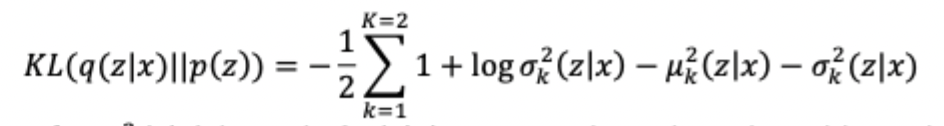

In [10]:
def kl_divergence(z_mu, z_logvar):
    #z_logvar.exp() refers to variance^2 because opposing operation from log is exp
    return -0.5* torch.sum(1 + z_logvar - z_mu.pow(2) - z_logvar.exp())

### VAE_loss fn
Reconstruction loss to compare x and x^ via Binary Cross-Entropy loss fn and add KL divergence (bce is also called log loss)
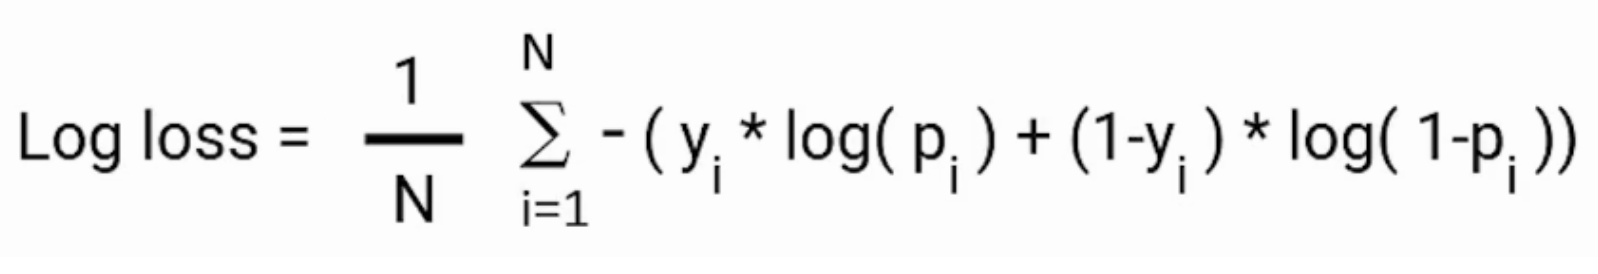

In [11]:
def VAE_loss(x_hat, x, z_mu, z_logvar):
    # print('xhat: ', x_hat.size(), '\nx: ', x.size())
    # Compare x and x^ via Binary Cross Entropy loss (reconstruction loss)
    bce = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')

    # Calculate the KL Divergence between distribution q(z|x) and p(z)
    # (regularization)
    kld = kl_divergence(z_mu=z_mu, z_logvar=z_logvar)

    # return the  total loss = bce + kl divergence to ensure penalization
    # of deviations from std normal distribution
    return bce + kld

### fashion_mnist_train fn

In [12]:
def vae_fashion_mnist_train(model, train_data, epoch, optimizer, device):
    # Create initial loss
    vae_total_loss = 0

    # For each batch of 32 images from the training data
    for data, _ in train_data:
        # print('\n*******\nbatch num: ', batch_num, '\ndims: ', data.size())
        
        # Start optimizer gradient/clear prior gradient
        optimizer.zero_grad()

        # Flatten images
        x = data.reshape(-1, 784).to(device)
        # print('\nflattened dims: ', x.size())

        # **** Begin moving forward through nn - encoder, reparametization, decoder ****
        x_hat, z_mu, z_logvar = model.VAE_forward(x)
        # **** End of moving forward ****

        # Calculate loss
        batch_loss = VAE_loss(x_hat, x, z_mu, z_logvar)

        # Add current batch's calculated loss to the total loss within current epoch
        vae_total_loss += batch_loss.item()

        # Backpropagate nn
        batch_loss.backward()

        # Request optimizer to evaluate the parameters and adjust (w and b)
        optimizer.step()

    print(f"Epoch #{epoch} training average loss: {vae_total_loss/len(train_data.dataset)}")
    return vae_total_loss/len(train_data.dataset)
    

## Train model x amount of epochs

In [13]:
# Create device to process certain functions faster using cuda or cpu depending availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device available: ', device)

# Create VAE model from class VAE
vae_model = VAE().to(device)
best_val_weights = None
best_val_epoch = 0
last_training_weights = None

# Number of passes for training
epochs = 200

# Track loss
epoch_loss_records = []

# Establish learning rate for optimizer
lr = 0.001

# Establish values for early stopping and avoiding overfitting
best_val_loss = float('inf')
epoch_val_loss = []
patience = 5 # How many epochs before change happens
val_freq = 5 # Create a subset validation each 5 epochs
no_change = 0
min_delta = 0.001

# Establish optimizer to ensure parameters for each layer are adjusted with each pass via gradient descent
print('VAE parameters: ', vae_model.parameters())
optimizer = optim.Adam(vae_model.parameters(), lr=lr)

# Run training x number of epochs
for epoch in range(epochs):
    # Set model to train
    vae_model.train()
    
    # Train model
    loss = vae_fashion_mnist_train(vae_model, train_data, epoch, optimizer, device)
    
    # Append epoch's loss for graph
    epoch_loss_records.append(loss)

    # Evaluate model using validation data
    if (epoch+1) % val_freq == 0:

        # Set VAE model to evaluate and initiate val loss
        vae_model.eval()

        # Set gradient to 0/disable only for validation
        with torch.no_grad():

            # Obtain validation loss
            val_total_loss = 0
            for data,_ in val_data:
                # Same steps from training except backwards and optimizer step
                # Because it is for validation, there is no need to apply backpropagation or optimizer
                x_val = data.reshape(-1, 784).to(device)
                xv_hat, zv_mu, zv_logvar = vae_model.VAE_forward(x_val)
                val_loss = VAE_loss(xv_hat, x_val, zv_mu, zv_logvar)
                val_total_loss += val_loss.item()
            
            # average val loss
            ave_val_loss = val_total_loss/len(val_data.dataset)
            epoch_val_loss.append(ave_val_loss)
            print(f"Epoch #{epoch} average validation loss: {ave_val_loss}")

        # If current validation loss + min_delta is less than best validation loss, then update best val loss
        if (ave_val_loss+min_delta) < best_val_loss:
            best_val_loss = ave_val_loss
            no_change = 0 # Resetting amount of epochs counter
            best_val_weights = copy.deepcopy(vae_model.state_dict())
            best_val_epoch = epoch
            print(f'Best validation updated to {best_val_loss}')
        else:
            no_change+=1 # Increase so that it may reach max patience amount
            print(f'num epochs with no change {no_change}')
        
        # Evaluate if patience maxed so the epochs can be stopped or not and avoid overfitting
        if no_change == patience:
            print(f'Early stopping due to change in loss < min delta {min_delta} at epoch {epoch} of {epochs}')
            last_training_weights = copy.deepcopy(vae_model.state_dict())
            break
        
        # Record last known weights for model before ending
        if epoch == epochs-1:
            last_training_weights = copy.deepcopy(vae_model.state_dict())

Device available:  cpu
VAE parameters:  <generator object Module.parameters at 0x15f63a7a0>
Epoch #0 training average loss: 292.135166422526
Epoch #1 training average loss: 272.59741935221354
Epoch #2 training average loss: 269.9813116861979
Epoch #3 training average loss: 268.27905387369793
Epoch #4 training average loss: 267.14110786946617
Epoch #4 average validation loss: 266.10414404296876
Best validation updated to 266.10414404296876
Epoch #5 training average loss: 266.2603807779948
Epoch #6 training average loss: 265.6730491536458
Epoch #7 training average loss: 265.11531392415367
Epoch #8 training average loss: 264.5990060221354
Epoch #9 training average loss: 264.2114567871094
Epoch #9 average validation loss: 263.7117861328125
Best validation updated to 263.7117861328125
Epoch #10 training average loss: 263.82394873046877
Epoch #11 training average loss: 263.5886205240885
Epoch #12 training average loss: 263.3344160563151
Epoch #13 training average loss: 262.99602502441405
Epo

## Display Training curves (Loss vs Validation vs epochs)

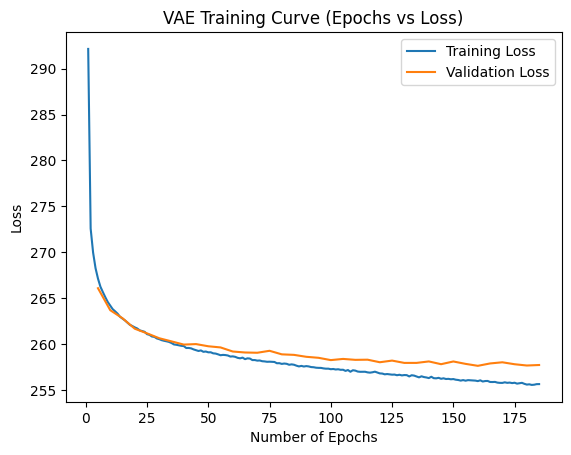

In [14]:
plt.plot(range(1, len(epoch_loss_records)+1), epoch_loss_records, label='Training Loss')
plt.plot(range(val_freq, val_freq*len(epoch_val_loss)+1, val_freq), epoch_val_loss, label='Validation Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('VAE Training Curve (Epochs vs Loss)')
plt.legend()
plt.show()

## Display 2D Scatterplot for a random subset of 5000 input images from z values/images output by encoder after parametization ==> based on weights from lowest loss in validation

Number of epochs for best validation result and weights:  159


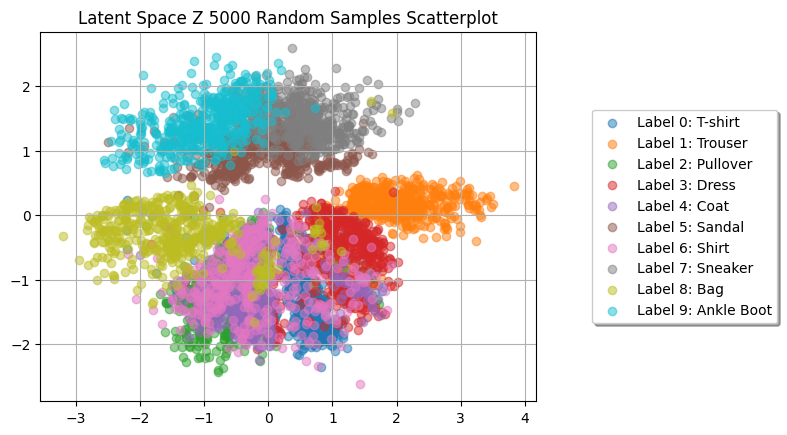

In [15]:
z_samples = []
z_labels = []
# Get random subset of indexes from original training data, then extract first 5000
subset_index = torch.randperm(len(train))[:5000]

# Get subset via DataLoader
subset_data = DataLoader(Subset(train, subset_index), batch_size=32, shuffle=False)

# Load best weights from validation, set val mode, start the gradient descent to 0 then and apply nn functions
vae_model.load_state_dict(best_val_weights)
print('Number of epochs for best validation result and weights: ', best_val_epoch)
vae_model.eval()
with torch.no_grad():
    for data, label in subset_data:
        x = data.reshape(-1, 784).to(device)
        z_mu, z_logvar = vae_model.VAE_encoder(x)
        z = vae_model.VAE_reparametization(z_mu, z_logvar)
        z_samples.append(z)
        z_labels.append(label)

# Use torch.cat to unify all resulting z from each batch
z_samples = torch.cat(z_samples, 0)
z_labels = torch.cat(z_labels, 0)

# Get colors for 10 categories
colors = plt.cm.colors.TABLEAU_COLORS

# Display scatterplot of z values obtained per label
for category, color in enumerate(colors):
    plt.scatter(
        z_samples[z_labels == category,0], 
        z_samples[z_labels == category, 1],
        alpha=0.5,
        color=color,
        label=f'Label {category}: {labels_map[category]}'
    )
# plt.scatter(z_samples[:,0], z_samples[:, 1], alpha=0.5, cmap=cmap)
plt.title('Latent Space Z 5000 Random Samples Scatterplot')
plt.grid(True)
plt.legend(loc='right', bbox_to_anchor=(1.5, 0.5), fancybox=True, shadow=True)
plt.show()

## Second 2D Scatterplot for same random subset of 5000 input images ==> based on weights obtained during last training epoch

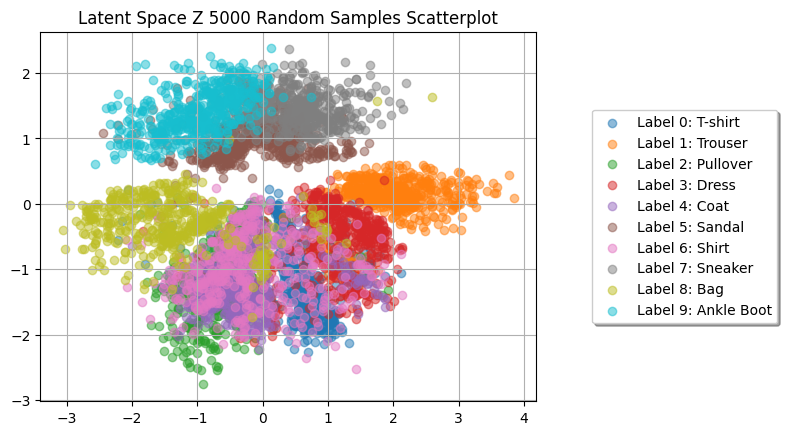

In [16]:
z_samples = []
z_labels = []

# Load best weights from validation, set val mode, start the gradient descent to 0 then and apply nn functions
vae_model.load_state_dict(last_training_weights)
vae_model.eval()
with torch.no_grad():
    for data, label in subset_data:
        x = data.reshape(-1, 784).to(device)
        z_mu, z_logvar = vae_model.VAE_encoder(x)
        z = vae_model.VAE_reparametization(z_mu, z_logvar)
        z_samples.append(z)
        z_labels.append(label)

# Use torch.cat to unify all resulting z from each batch
z_samples = torch.cat(z_samples, 0)
z_labels = torch.cat(z_labels, 0)

# Get colors for 10 categories
colors = plt.cm.colors.TABLEAU_COLORS

# Display scatterplot of z values obtained per label
for category, color in enumerate(colors):
    plt.scatter(
        z_samples[z_labels == category,0], 
        z_samples[z_labels == category, 1],
        alpha=0.5,
        color=color,
        label=f'Label {category}: {labels_map[category]}'
    )
# plt.scatter(z_samples[:,0], z_samples[:, 1], alpha=0.5, cmap=cmap)
plt.title('Latent Space Z 5000 Random Samples Scatterplot')
plt.grid(True)
plt.legend(loc='right', bbox_to_anchor=(1.5, 0.5), fancybox=True, shadow=True)
plt.show()

## Display of 15x15 gridplot with generated images output by decoder from complete range of z values across the two components of z - using weights from smallest loss in validation

range:  -3 3


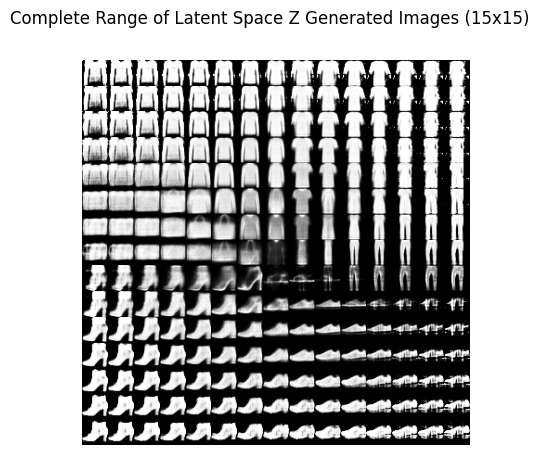

In [17]:
grid_size = 15

# Check min and max values from z_samples to determine complete range of z
range_val = math.ceil(max(abs(z_samples.min()), abs(z_samples.max())))
print('range: ', -range_val+1, range_val-1)

# Round up and use to create a list of 15 elements with equal interval amount
z_val_range = np.linspace(-range_val, range_val, grid_size)

# Create a grid with range values, i.e. a 15x15 matrix
zx, zy = np.meshgrid(z_val_range, z_val_range)

# Create figure to hold all subplots
fig = plt.figure(figsize=(5,5))

# Navigate through rows and then columns to assing a subplot based on matrix
for i in range(grid_size):
    for j in range(grid_size):

        # Create a tensor from a row of values on zx, and a row from zy
        z = torch.tensor([zx[i,j], zy[i,j]], dtype=torch.float32)
        
        # Load weights for best validaiton, set model to evaluate, and remove gradient temporarily
        vae_model.load_state_dict(best_val_weights)
        vae_model.eval()
        with torch.no_grad():
            x_hat = vae_model.VAE_decoder(z)
            # Reshape x_hat from 784 to 28x28 to ensure img format
            x_hat = x_hat.reshape(28,28)

        # Create subplot for image created, assigning location within 15x15 display
        img = plt.subplot(grid_size, grid_size, i*grid_size+j+1)
        img.imshow(x_hat, cmap='gray')
        img.axis('off')

# Adjust title and display for all subplots
plt.suptitle('Complete Range of Latent Space Z Generated Images (15x15)')
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

## Display 2D plotgrid of 5 varying images per each category (10x5) - based on weights from smallest validation loss

/var/folders/tg/f26try5n4pq7thttks3b9fs00000gn/T/ipykernel_35815/131614122.py:38: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  varied_z = z_val + np.random.normal(0, 1, size=z_val.shape).astype('float32')


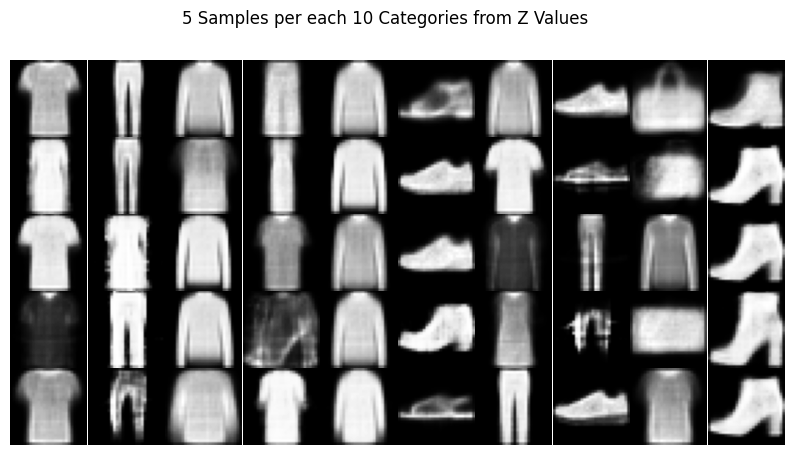

In [19]:
# Storage for z values based on category
z_cat_vals = {cat: [] for cat in range(len(labels_map))}

# Run VAE functions up to reparametization to obtain the z values
vae_model.load_state_dict(best_val_weights)
vae_model.eval()
with torch.no_grad():
    for data,labels in all_train_data:
        x = data.reshape(-1, 784).to(device)
        z_mu, z_logvar = vae_model.VAE_encoder(x)
        z = vae_model.VAE_reparametization(z_mu, z_logvar)

        # Extract labels for reproduced z samples within batch and append z to corresponding key
        for val,label in zip(z, labels):
            z_cat_vals[label.item()].append(val)
        
# Find what z values are representative of a each category by finding the mean of tensors with 2 values
ave_z = {}
for label in z_cat_vals:
   ave_z[label] = torch.mean(torch.stack(z_cat_vals[label]), axis=0)

# 10 cols x 5 rows grid of images
num_samples = 5
img_fig, subplot = plt.subplots(5,10, figsize=(10,5))

# Map each value z's image as subplot
for i in range(len(labels_map)):
    z_vals = []
    # Get z value and plot
    z_val = ave_z[i]
    with torch.no_grad():
        image = vae_model.VAE_decoder(z_val).reshape(28,28)
    subplot[0,i].imshow(image, cmap='gray')
    subplot[0,i].axis('off')

    for j in range(1, num_samples):
        # Get 4 additional values within range representative of samples around mean value z found
        varied_z = z_val + np.random.normal(0, 1, size=z_val.shape).astype('float32')

        with torch.no_grad():
            image = vae_model.VAE_decoder(varied_z)
            image = image.reshape(28,28)
            # print(image.size())
            subplot[j,i].imshow(image, cmap='gray')
            subplot[j,i].axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.suptitle('5 Samples per each 10 Categories from Z Values')
plt.show()